In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from PIL import Image, ImageDraw
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.globals import ThemeType
from wordcloud import WordCloud

In [2]:
with Path.open(Path("maps.json"), "r", encoding="utf-8") as f:
    maps: dict[str, dict[str, str] | list[str] | dict[str, list[str]]] = json.load(f)
type_tag_map: dict[str, dict[str, list[str]]] = maps["type_tag_map"]  # type: ignore[reportAssignmentType]

job_data = pl.scan_csv("job.csv")

In [3]:
job_map = (
    job_data.select(pl.col("city").value_counts(sort=True).alias("count")).unnest(
        "count"
    )
).collect()
map_data: list[tuple] = list(zip(job_map["city"], job_map["count"], strict=False))

_map = (
    Map(init_opts=opts.InitOpts(theme=ThemeType.LIGHT, renderer="svg"))
    .add(
        series_name="数据类人才需求",
        data_pair=map_data,
        maptype="china-cities",
        is_map_symbol_show=False,
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="数据类人才需求省际分布图"),
        visualmap_opts=opts.VisualMapOpts(
            min_=int(job_map["count"].min()),  # type: ignore[reportArgumentType]
            max_=int(job_map["count"].max()),  # type: ignore[reportArgumentType]
            is_calculable=True,
            range_text=["Max", "Min"],
            range_color=["lightskyblue", "yellow", "orangered"],
            pos_left="30%",
            pos_bottom="15%",
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

_map.render_notebook()

In [ ]:
# from pyecharts.render import make_snapshot
# from snapshot_selenium import snapshot as driver

# make_snapshot(driver, _map.render(), "maplot.svg")

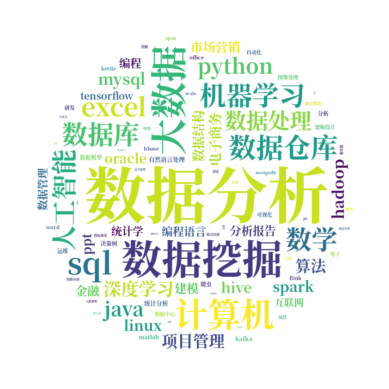

In [4]:
# select tag which in types
tags = job_data.select("tags").collect()
tag_counts = Counter(
    item for row in tags.rows() for v in row if v for item in v.split(",")
)
tag_set = {j for i in type_tag_map.values() for j in i}
tag_counts = {k: v for k, v in tag_counts.items() if k in tag_set}

# Create a oval mask
mask = Image.fromarray(np.full((800, 800), 255, np.uint8))
mask_draw = ImageDraw.Draw(mask)
mask_draw.ellipse((50, 50, 750, 750), fill=0)
mask = np.array(mask)

# Generate the wordcloud with the mask
wordcloud = WordCloud(
    font_path="/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc",
    background_color="white",
    margin=10,
    mask=mask,
).generate_from_frequencies(frequencies=tag_counts)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig("skill_tag.svg", dpi=1600)
plt.show()